# Aim 
To understand backpropagation by manually computing it for a simple computation graph
# Introduction 
Backpropagation helps us compute the gradient of a composite function efficiently. 

In [25]:
# # Value Object Explained

# ## What is a Value Object?

# A Value object represents a variable in a computation and tracks two key pieces of information:
# 1. The current value of the variable
# 2. How this variable affects the final output (its gradient)

from graphviz import Digraph

from graphviz import Digraph

class Value:
    def __init__(self, data, label="", prev=[], op=""):
        self.data = data
        self.grad = 0
        self.label = label
        self.prev = prev
        self.op = op
        
    def __add__(self, other):
        other = other if isinstance(other, Value) else Value(other)
        out = Value(self.data + other.data, prev=[self, other], op="+")
        return out
    
    def __mul__(self, other):
        other = other if isinstance(other, Value) else Value(other)
        out = Value(self.data * other.data, prev=[self, other], op="*")
        return out
    
    def __rmul__(self, other):
        return self * other
        
    def __repr__(self):
        return f"Value(label={self.label}, data={self.data}, grad={self.grad})"
    
    def _build(self):
        """builds a set of all nodes and edges in a graph"""
        nodes, edges = set(), set()
        
        def build(v):
            if v not in nodes:
                nodes.add(v)
                for child in v.prev:
                    edges.add((child, v))
                    build(child)
        build(self)
        return nodes, edges
    
    def draw_dot(self):
        """Creates a visualization of the computation graph"""
        dot = Digraph(format='svg', graph_attr={'rankdir': 'LR'})
        
        nodes, edges = self._build()
        
        # Add all nodes to graph
        for n in nodes:
            uid = str(id(n))
            # Create a node label with data and optional label
            node_label = f"data {n.data:.4f}"
            if n.label:
                node_label += f" | label {n.label}"
                
            if n.grad:
                node_label += f" | grad {n.grad}"
            
            # Add the node as a box
            dot.node(name=uid, 
                    label=node_label,
                    shape='record')
            
            # If it's an operation result, add the operation node
            if n.op:
                op_id = uid + n.op
                dot.node(name=op_id, label=n.op, shape='circle')
                dot.edge(op_id, uid)
        
        # Add edges between nodes
        for n1, n2 in edges:
            dot.edge(str(id(n1)), str(id(n2)) + n2.op)
        
        return dot

# Example Problem

Consider a concrete example with following equations:

```
L = d * f
d = e + c 
e = a * b
Where a=2, b=-3, c=10, f=-2 
```

We aim to minimize the loss function L. To achieve this, we need to calculate the partial derivatives (gradients) with respect to each variable in our computation:

* ∂L/∂a: How L changes with respect to a
* ∂L/∂b: How L changes with respect to b
* ∂L/∂c: How L changes with respect to c
* ∂L/∂d: How L changes with respect to d
* ∂L/∂e: How L changes with respect to e
* ∂L/∂f: How L changes with respect to f

These gradients tell us how to adjust each variable to reduce L. While we could calculate these gradients manually, backpropagation provides an efficient algorithm to compute them automatically by leveraging the computational graph structure.

# The forward pass 

The forward pass is the process of computing the final output (in this case, L) by evaluating each expression in our computation graph from inputs to outputs. It follows the natural order of calculations.

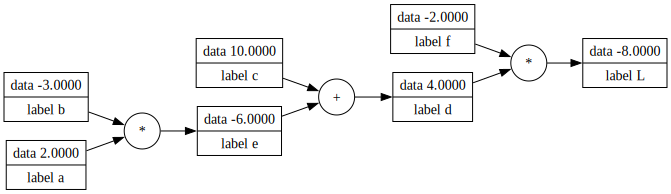

In [26]:
a = Value(2.0, label='a')
b = Value(-3.0, label='b')
c = Value(10.0, label='c')
f = Value(-2.0, label ='f')
e = a*b; e.label = 'e'
d = e + c; d.label = 'd'
L = d * f ; L.label = 'L'
L.draw_dot()

# Gradient computation by backpropagation

The backward pass is where we compute all gradients by moving backwards through our computational graph. We start at the output (L) and move towards the inputs (a, b, c, f). 

Our equations
```
L = d * f
d = e + c 
e = a * b
```

1. Start at L (∂L/∂L = 1):

* By definition, ∂L/∂L = 1.0
* This serves as our starting point


2. Compute ∂L/∂d and ∂L/∂f:

* For equation L = d * f:
* ∂L/∂d = f = -2.0
* ∂L/∂f = d = 4.0


3. Compute ∂L/∂e and ∂L/∂c:

* For equation d = e + c:
* ∂L/∂c = ∂L/∂d * ∂d/∂c = -2.0 * 1 = -2.0
* ∂L/∂e = ∂L/∂d * ∂d/∂e = -2.0 * 1 = -2.0


4. Compute ∂L/∂a and ∂L/∂b:

* For equation e = a * b:
* ∂L/∂a = ∂L/∂e * ∂e/∂a = -2.0 * b = -2.0 * (-3) = 6.0
* ∂L/∂b = ∂L/∂e * ∂e/∂b = -2.0 * a = -2.0 * 2 = -4.0

Once we have these gradients, we can use them to update our variables:

In [27]:
L.grad = 1.0; f.grad = 4.0; c.grad = -2.0; d.grad = -2 ; e.grad = -2.0; a.grad = 6; b.grad = -4

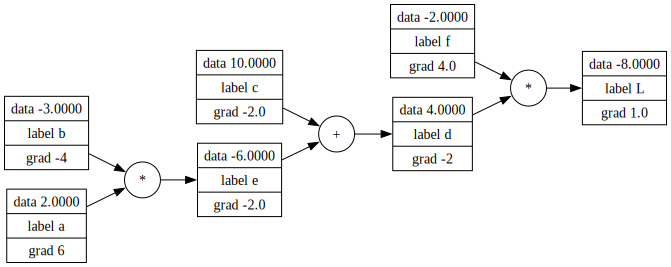

In [28]:
L.draw_dot()

# Minimize L using gradient / Gradient Descent Update

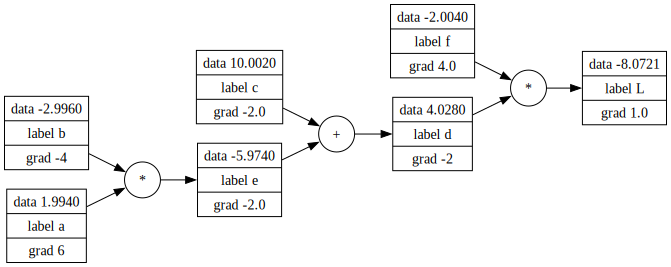

In [29]:
# Set learning rate
lr = 0.001

# Update parameters
a.data -= lr * a.grad  # 2.0 - 0.001 * 6.0 = 1.994
b.data -= lr * b.grad  # -3.0 - 0.001 * (-4.0) = -2.996
c.data -= lr * c.grad  # 10.0 - 0.001 * (-2.0) = 10.002
f.data -= lr * f.grad  # -2.0 - 0.001 * 4.0 = -2.004

# Recompute forward pass
e.data = a.data * b.data
d.data = e.data + c.data
L.data = d.data * f.data

L.draw_dot()

The loss value has decreased from -8.0 to -8.0721, showing our updates moved in the right direction. This happened because:

1. Each variable was adjusted in proportion to its gradient
2. The learning rate (0.001) ensured small, controlled updates
3. The negative change in L indicates we're successfully minimizing the loss function

If we continued this process iteratively, L would continue to decrease until reaching a local minimum. This is the core principle behind how neural networks learn from data.